# 0.Import Librairies :

In [1]:
import pandas as pd
import numpy as np 
import glob 
import warnings 
from collections import Counter
warnings.filterwarnings("ignore")
import plotly.express as px 
import seaborn as sns 
import matplotlib.pyplot as plt 
import lightgbm as lgbm 
from sklearn.model_selection import StratifiedKFold
import math
import os 
import random
import torch 
import torch.nn as nn
from transformers import AdamW
from torch.utils.data import Dataset , DataLoader
from colorama import Fore , Style
r__=Fore.RED
g__=Fore.GREEN
st__=Style.RESET_ALL

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
seed_everything(42)

# 1. Helper functions :

In [4]:
def wap(row) :
    denom = row.ask_size1 + row.bid_size1
    return ((row.bid_price1 * row.ask_size1 + row.ask_price1 * row.bid_size1)/denom)

In [5]:
def log_return(list_prices):
    return np.log(list_prices).diff()

In [6]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [7]:
def custom_loss(ytrue,ypred) :
    squared_residual = (ytrue-ypred)**2/ytrue
    grad = squared_residual
    hess = np.ones(len(ytrue))
    
    return grad,hess

In [8]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [9]:
def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


In [10]:
def custom_rmspe_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    residual = residual ** 2 / y_true
    residual = np.mean(residual)
    return "eval_RMSPE", math.sqrt(residual), False

In [11]:
def simple_volatility(series_prix):
    mx = np.max(series_prix)
    mn = np.min(series_prix)
    moy = np.mean(series_prix)
    vol = (moy-mn)/(mx-mn)
    return vol

In [12]:
def count_unique(series):
    return len(np.unique(series))

# 2. Get a Look at Datas:

In [13]:
# load train datas 
train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")

In [14]:
# get a look at train data.
train.head() 

stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747

In [15]:
# get a look at test data 
test = pd.read_csv("../input/optiver-realized-volatility-prediction/test.csv")
test.head()

stock_id  time_id row_id
0         0        4    0-4
1         0       32   0-32
2         0       34   0-34

In [16]:
# load book train for stock_id = 1
book_train_stock_id_1 = pd.read_parquet("../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=1")

In [17]:
# get a look at book train for stock_id = 1
book_train_stock_id_1.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.000754    1.001542    1.000689    1.001607   
1        5                  1    1.000754    1.001673    1.000689    1.001739   
2        5                  2    1.000754    1.001411    1.000623    1.001476   
3        5                  3    1.000754    1.001542    1.000689    1.001607   
4        5                  4    1.000754    1.001476    1.000623    1.001542   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          1         25         25        100  
1         26         60         25        100  
2          1         25         25        125  
3        125         25        126         36  
4        100        100         25         25

In [18]:
# load trade train for stock_id = 1
trade_train_stock_id_1 = pd.read_parquet("../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=1")

In [19]:
# get a look at trade train .
trade_train_stock_id_1.head()

time_id  seconds_in_bucket     price  size  order_count
0        5                 28  1.002080   553           11
1        5                 39  1.002460     8            3
2        5                 42  1.002308   147            4
3        5                 44  1.002788     1            1
4        5                 51  1.002657   100            2

# 3. EDA : 

In [20]:
nb_time_id_per_stock_id = Counter(train["stock_id"])
train["nb_time_id"]  = train["stock_id"].map(nb_time_id_per_stock_id)
fig = px.pie(data_frame=train,names="nb_time_id",values="nb_time_id",title="Percentage of number of time_id for each stock_id")
fig.update_layout(title={"xanchor":"center","x":0.5})
fig.show()

We notice that more than 95 % of stock_id have the same number of time_id, which is 3830 number of time_id.

## Book order features explorations :

In [21]:
#  Compute the weighted averaged price for each option.
book_train_stock_id_1["wap"] = book_train_stock_id_1.apply(wap,axis=1)

In [22]:
book_train_stock_id_1["squared_wap"] = book_train_stock_id_1["wap"] **2

In [23]:
# Compute the second weighted averaged price for each option 
book_train_stock_id_1.loc[:,"wap1"] = (book_train_stock_id_1['bid_price2'] * book_train_stock_id_1['ask_size2']+book_train_stock_id_1['ask_price2'] * book_train_stock_id_1['bid_size2'])  / (
                                      book_train_stock_id_1['bid_size2']+ book_train_stock_id_1[
                                  'ask_size2'])

In [24]:
book_train_stock_id_1.loc[:,"supply_demand"] = (book_train_stock_id_1.loc[:,"ask_size1"]+book_train_stock_id_1.loc[:,"ask_size2"])\
/(book_train_stock_id_1.loc[:,"bid_size1"] + book_train_stock_id_1.loc[:,"bid_size2"])

In [25]:
book_train_stock_id_1.loc[:,"log_supply_demand"] = book_train_stock_id_1.groupby("time_id")["supply_demand"].apply(log_return)

In [26]:
book_train_stock_id_1.loc[:,"avg_wap"] = book_train_stock_id_1.loc[:,"wap"] + \
book_train_stock_id_1.loc[:,"wap1"]/2

In [27]:
# compute the log return for each option .
book_train_stock_id_1["log_return"]=book_train_stock_id_1.groupby("time_id")["wap"].\
apply(log_return)

In [28]:
book_train_stock_id_1.loc[:,"log_return1"] = book_train_stock_id_1.groupby("time_id")["wap1"].apply(log_return)

In [29]:
book_train_stock_id_1.loc[:,"log_squared_wap"] = book_train_stock_id_1.groupby("time_id")["squared_wap"].apply(log_return)

In [30]:
book_train_stock_id_1.loc[:,"log_avg_wap"] = book_train_stock_id_1.groupby("time_id")\
["avg_wap"].apply(log_return)

In [31]:
book_train_stock_id_1["diff_bid_price"] = book_train_stock_id_1["bid_price1"]-\
book_train_stock_id_1["bid_price2"]

In [32]:
book_train_stock_id_1["diff_ask_price"] = book_train_stock_id_1["ask_price2"]-\
book_train_stock_id_1["ask_price1"]

In [33]:
book_train_stock_id_1["log_diff_ask_price"] = book_train_stock_id_1.groupby("time_id")["diff_ask_price"].\
apply(log_return)

In [34]:
book_train_stock_id_1["log_diff_bid_price"] = book_train_stock_id_1.groupby("time_id")["diff_bid_price"].\
apply(log_return)

In [35]:
book_train_stock_id_1["wap3"] = ((book_train_stock_id_1["bid_price1"] * book_train_stock_id_1["bid_size1"])+\
                                 (book_train_stock_id_1["ask_price1"] * book_train_stock_id_1["ask_size1"]))/\
(book_train_stock_id_1["ask_price1"] + book_train_stock_id_1["ask_size1"])

In [36]:
book_train_stock_id_1["log_wap3"] = book_train_stock_id_1.groupby("time_id")["wap3"].\
apply(log_return)

In [37]:
book_train_stock_id_1["wap_balance"] = abs(book_train_stock_id_1["wap"]-\
                                           book_train_stock_id_1["wap1"])+1

In [38]:
book_train_stock_id_1["log_wap_balance"] = book_train_stock_id_1.groupby("time_id")["wap_balance"]\
.apply(log_return)

In [39]:
book_train_stock_id_1["price_spread"] = book_train_stock_id_1["ask_price1"] - \
book_train_stock_id_1["bid_price1"]

In [40]:
book_train_stock_id_1["log_price_spread"] = book_train_stock_id_1.groupby("time_id")["price_spread"]\
.apply(log_return)

In [41]:
book_train_stock_id_1["price_spread_1"] = book_train_stock_id_1["ask_price2"] - \
book_train_stock_id_1["bid_price2"]

In [42]:
book_train_stock_id_1["log_price_spread_1"] = book_train_stock_id_1.groupby("time_id")["price_spread_1"].\
apply(log_return)

In [43]:
book_train_stock_id_1.loc[:,"avg_wap"] = book_train_stock_id_1.loc[:,"wap"] + \
book_train_stock_id_1.loc[:,"wap1"]/2

In [44]:
book_train_stock_id_1["price_spread_avg"] = book_train_stock_id_1["price_spread"] + \
book_train_stock_id_1["price_spread_1"] /2

In [45]:
book_train_stock_id_1["price_spread_diff"] = book_train_stock_id_1["price_spread_1"] - \
book_train_stock_id_1["price_spread"]

In [46]:
book_train_stock_id_1["log_avg_wap"] = book_train_stock_id_1.groupby("time_id")["avg_wap"].apply(log_return)

In [47]:
book_train_stock_id_1["log_price_spread_avg"] = book_train_stock_id_1.groupby("time_id")["price_spread_avg"].apply(log_return)

In [48]:
book_train_stock_id_1["log_price_spread_diff"] = book_train_stock_id_1.groupby("time_id")["price_spread_diff"].\
apply(log_return)

In [49]:
book_train_stock_id_1["total_volume"] = book_train_stock_id_1["ask_size1"]+\
book_train_stock_id_1["bid_size1"] + book_train_stock_id_1["ask_size2"] +\
book_train_stock_id_1["bid_size2"]

In [50]:
book_train_stock_id_1["volume_imbalance"] = (book_train_stock_id_1["bid_size1"] +\
book_train_stock_id_1["bid_size2"]) - (book_train_stock_id_1["ask_size1"]+\
                                       book_train_stock_id_1["ask_size2"])

In [51]:
book_train_stock_id_1["volume_imbalance"] = 1 + book_train_stock_id_1["volume_imbalance"].abs()

In [52]:

book_train_stock_id_1["log_volume_imbalance"] = book_train_stock_id_1.groupby("time_id")["volume_imbalance"]\
.apply(log_return)

In [53]:
book_train_stock_id_1["bid_size"] = book_train_stock_id_1.loc[:,"bid_size1"] + book_train_stock_id_1.loc[:,"bid_size2"]

In [54]:
book_train_stock_id_1["ask_size"] = book_train_stock_id_1.loc[:,"ask_size1"] + book_train_stock_id_1.loc[:,"ask_size2"]

In [55]:
book_train_stock_id_1 = book_train_stock_id_1.loc[~((book_train_stock_id_1["log_return"].isnull())|\
                                                  (book_train_stock_id_1["log_return1"].isnull())|(\
                                                    book_train_stock_id_1["log_supply_demand"].isnull())),:]

In [56]:
# book order for stock_id= 1 and time_id=5
book_train_stock_id_1_time_id_5 = book_train_stock_id_1.loc[book_train_stock_id_1["time_id"]==5,:]

In [57]:
fig = px.line(data_frame=book_train_stock_id_1_time_id_5,x="seconds_in_bucket",y="wap",\
             title="WAP of stock_id_1,time_id_5")
fig.show()

In [58]:
fig = px.line(data_frame=book_train_stock_id_1_time_id_5,x="seconds_in_bucket",y="log_return",\
             title ="log return for stock_id_1,time_id_5")
fig.show()

In [59]:
fig = px.line(data_frame=book_train_stock_id_1_time_id_5,x="seconds_in_bucket",y="wap1",\
             title="WAP1 of stock_id_1,time_id_5")
fig.show()

In [60]:
fig = px.line(data_frame=book_train_stock_id_1_time_id_5,x="seconds_in_bucket",y="log_return1",\
             title="log_return1 of stock_id_1,time_id_5")
fig.show()

In [61]:
 create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return1':[realized_volatility],
        'log_squared_wap':[realized_volatility],
        "log_supply_demand":[realized_volatility],
        "log_avg_wap" :[realized_volatility],
        "supply_demand":[np.mean],
        "diff_bid_price":[np.mean],
        "diff_ask_price":[np.mean],
        "log_diff_ask_price":[realized_volatility],
        "log_diff_bid_price" :[realized_volatility],
        "log_wap3":[realized_volatility],
        'wap_balance':[np.mean],
        "price_spread_1" :[np.mean],
        'price_spread':[np.mean],
        "price_spread_avg":[np.mean],
        "price_spread_diff":[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
        "log_wap_balance":[realized_volatility],
        "log_price_spread":[realized_volatility],
        "log_price_spread_1":[realized_volatility],
        "log_price_spread_avg":[realized_volatility],
        "log_price_spread_diff":[realized_volatility],
        "log_volume_imbalance":[realized_volatility],
        "bid_size":[np.sum],
        "ask_size":[np.sum]
            }

In [62]:
book_features = book_train_stock_id_1.groupby("time_id").agg(create_feature_dict).reset_index()

In [63]:
book_features.columns = ["_".join(col) for col in book_features]

In [64]:
book_features.rename(columns={"time_id_":"time_id"},inplace=True)

realized_volatility_stock_id_1 = book_train_stock_id_1.groupby("time_id")["log_return"].\
apply(realized_volatility)

realized_volatility1_stock_id_1 =  book_train_stock_id_1.groupby("time_id")["log_return1"].\
apply(realized_volatility)

supply_demand_volatility = book_train_stock_id_1.groupby("time_id")["log_supply_demand"].apply(realized_volatility)

realized_volatility_squared_price = book_train_stock_id_1.groupby("time_id")["log_squared_wap"].apply(realized_volatility)

simple_volatility = book_train_stock_id_1.groupby("time_id")["wap"].apply(simple_volatility)

realized_diff_ask_price = book_train_stock_id_1.groupby("time_id")["diff_ask_price"].apply(\
                                                                                          realized_volatility)

realized_diff_bid_price = book_train_stock_id_1.groupby("time_id")["diff_bid_price"].apply(\
                                                                                          realized_volatility)

In [65]:
data_stock_id_1 = train.loc[train["stock_id"]==1,:]

In [66]:
data_stock_id_1["row_id"] = data_stock_id_1["stock_id"].astype("str").str.cat(data_stock_id_1\
                                                                             ["time_id"].astype("str"),sep="-")

In [67]:
book_features["stock_id"] = 1
book_features["row_id"] = book_features["stock_id"].astype("str").str.cat(book_features["time_id"]\
                                                                         .astype("str"),sep="-")

In [68]:
data_stock_id_1 = data_stock_id_1.merge(book_features,how="left",on="row_id")

In [69]:
data_stock_id_1.rename(columns={"stock_id_x":"stock_id","time_id_x":"time_id"},inplace=True)

In [70]:
del(data_stock_id_1["time_id_y"])
del(data_stock_id_1["stock_id_y"])

In [71]:
data_stock_id_1.rename(columns={"log_return_realized_volatility":"realized_volatility",\
                               "log_return1_realized_volatility":"realized1_volatility",\
                               "log_squared_wap_realized_volatility":"realized_squared_volatility",\
                               "log_supply_demand_realized_volatility":"supply_demand_volatilty",\
                               "log_diff_ask_price_realized_volatility":"realized_diff_ask_price",\
                               "log_diff_bid_price_realized_volatility":"realized_diff_bid_price"},\
                      inplace=True)

In [72]:
data_stock_id_1 = data_stock_id_1[["stock_id","time_id","target","realized_volatility","realized1_volatility",\
                                 'realized_squared_volatility','supply_demand_volatilty','log_avg_wap_realized_volatility',\
                                 'supply_demand_mean','diff_bid_price_mean','diff_ask_price_mean','realized_diff_ask_price',\
                                 'realized_diff_bid_price','log_wap3_realized_volatility','wap_balance_mean','price_spread_1_mean',\
                                  'price_spread_mean','price_spread_avg_mean','price_spread_diff_mean','volume_imbalance_mean',\
                                   'total_volume_mean','wap_mean','log_wap_balance_realized_volatility',
       'log_price_spread_realized_volatility',
       'log_price_spread_1_realized_volatility',
       'log_price_spread_avg_realized_volatility',
       'log_price_spread_diff_realized_volatility',
       'log_volume_imbalance_realized_volatility', 'bid_size_sum',
       'ask_size_sum']]

In [73]:
data_stock_id_1.rename(columns={"realized_volatility":"realized_t","realized1_volatility":"realized1_t"},inplace=True)

### Exploration and feature engineering related to realized_t feature:

In [74]:
for i in range(1,6) :
    data_stock_id_1[f"realized_t_{i}"] = data_stock_id_1["realized_t"].shift(i)

In [75]:
data_stock_id_1 = data_stock_id_1.reset_index(drop=True)

In [76]:
missing_realized_t_1 = np.where(data_stock_id_1["realized_t_1"].isna())[0]
missing_realized_t_2 = np.where(data_stock_id_1["realized_t_2"].isna())[0]
missing_realized_t_3 = np.where(data_stock_id_1["realized_t_3"].isna())[0]
missing_realized_t_4 = np.where(data_stock_id_1["realized_t_4"].isna())[0]
missing_realized_t_5 = np.where(data_stock_id_1["realized_t_5"].isna())[0]
for i in missing_realized_t_1 : 
    data_stock_id_1.loc[i,"realized_t_1"] = data_stock_id_1.loc[i,"realized_t"]
for i in missing_realized_t_2 : 
    data_stock_id_1.loc[i,"realized_t_2"] = data_stock_id_1.loc[i,"realized_t_1"]
for i in missing_realized_t_3 : 
    data_stock_id_1.loc[i,"realized_t_3"] = data_stock_id_1.loc[i,"realized_t_2"]
for i in missing_realized_t_4 : 
    data_stock_id_1.loc[i,"realized_t_4"] = data_stock_id_1.loc[i,"realized_t_3"]
for i in missing_realized_t_5 : 
    data_stock_id_1.loc[i,"realized_t_5"] = data_stock_id_1.loc[i,"realized_t_4"]

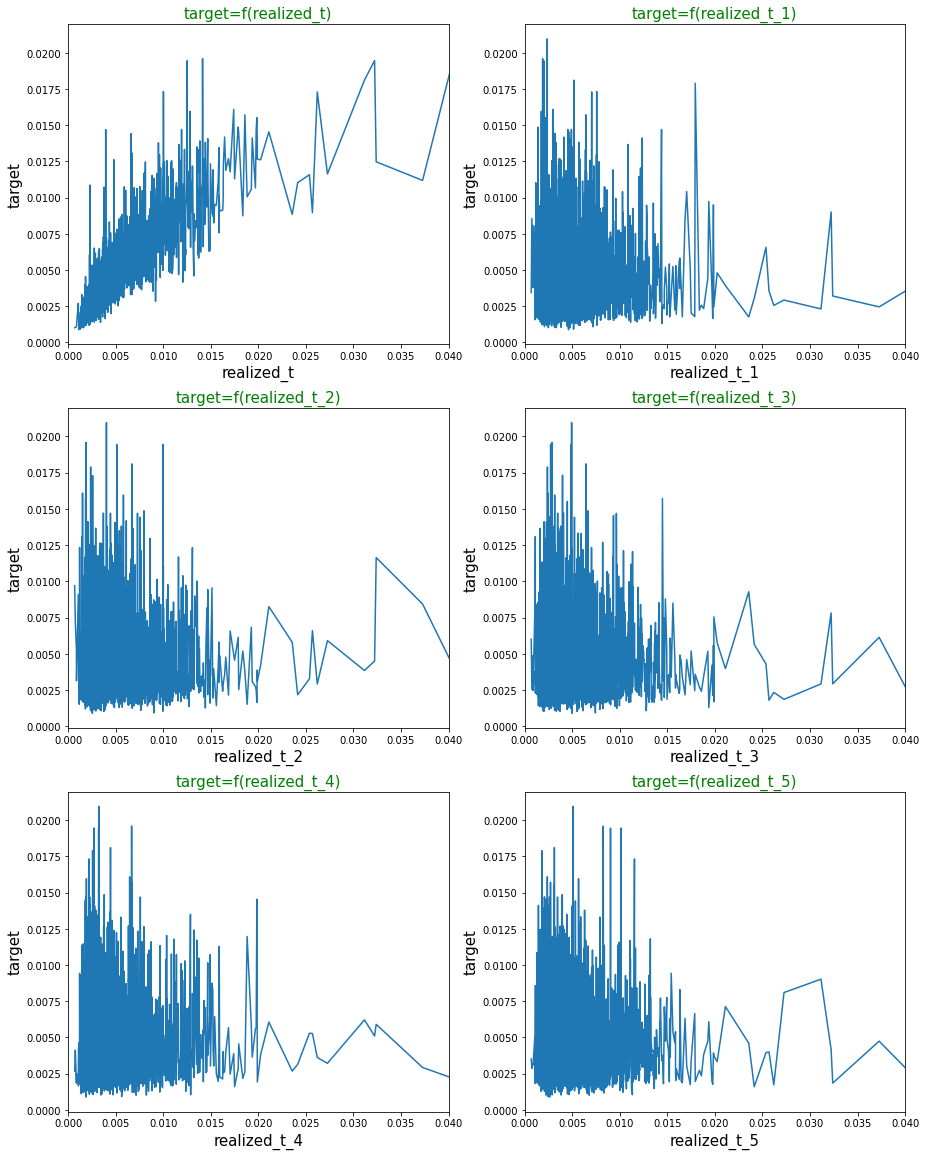

In [77]:
fix,axes = plt.subplots(3,2,figsize=(15,20))
for i in range(6) :
    if i != 0 :
       sns.lineplot(data_stock_id_1.loc[:,f"realized_t_{i}"].values,data_stock_id_1.loc[:,"target"].\
                 values,ax=axes[i//2,i%2])
       axes[i//2,i%2].set_xlabel(f"realized_t_{i}",size=15)
       axes[i//2,i%2].set_ylabel("target",size=15)
       axes[i//2,i%2].set_title(f"target=f(realized_t_{i})",size=15,color="green")
       axes[i//2,i%2].set_xlim([0,0.04])
    else : 
       sns.lineplot(data_stock_id_1.loc[:,"realized_t"].values,data_stock_id_1.loc[:,"target"].\
                 values,ax=axes[i//2,i%2])
       axes[i//2,i%2].set_xlabel("realized_t",size=15)
       axes[i//2,i%2].set_ylabel("target",size=15)
       axes[i//2,i%2].set_xlim([0,0.04])
       axes[i//2,i%2].set_title("target=f(realized_t)",size=15,color="green")

In [78]:
table_correlation = pd.DataFrame({f"realized_t_{i}":data_stock_id_1["target"].\
                                  corr(data_stock_id_1[f"realized_t_{i}"]) for i in range(1,6)},index=["target"])

In [79]:
table_correlation["realized_t"] = data_stock_id_1["target"].corr(data_stock_id_1["realized_t"])

<AxesSubplot:>

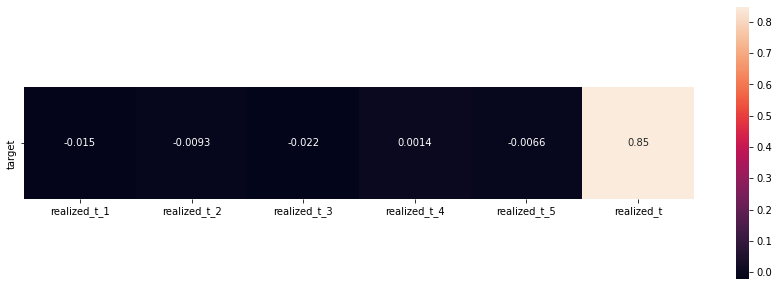

In [80]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.heatmap(table_correlation,annot=True,square=True)

> ==> High positive correlation between realized volatility in time t with target of time t.Moreover, we don't find any correlation between realized volatility of previous times and the current target. Besides the charts above can urge to study an eventual quadratic relation between target feature and realized_t_i features for i in {1,2,3,4,5}. 

In [81]:
for i in range(5) :
    if i == 0 : 
       data_stock_id_1["diff_t"] = data_stock_id_1["realized_t"] - data_stock_id_1[f"realized_t_{i+1}"]
    else :
        data_stock_id_1[f"diff_t_{i}"] = data_stock_id_1[f"realized_t_{i}"] - data_stock_id_1[f"realized_t_{i+1}"]

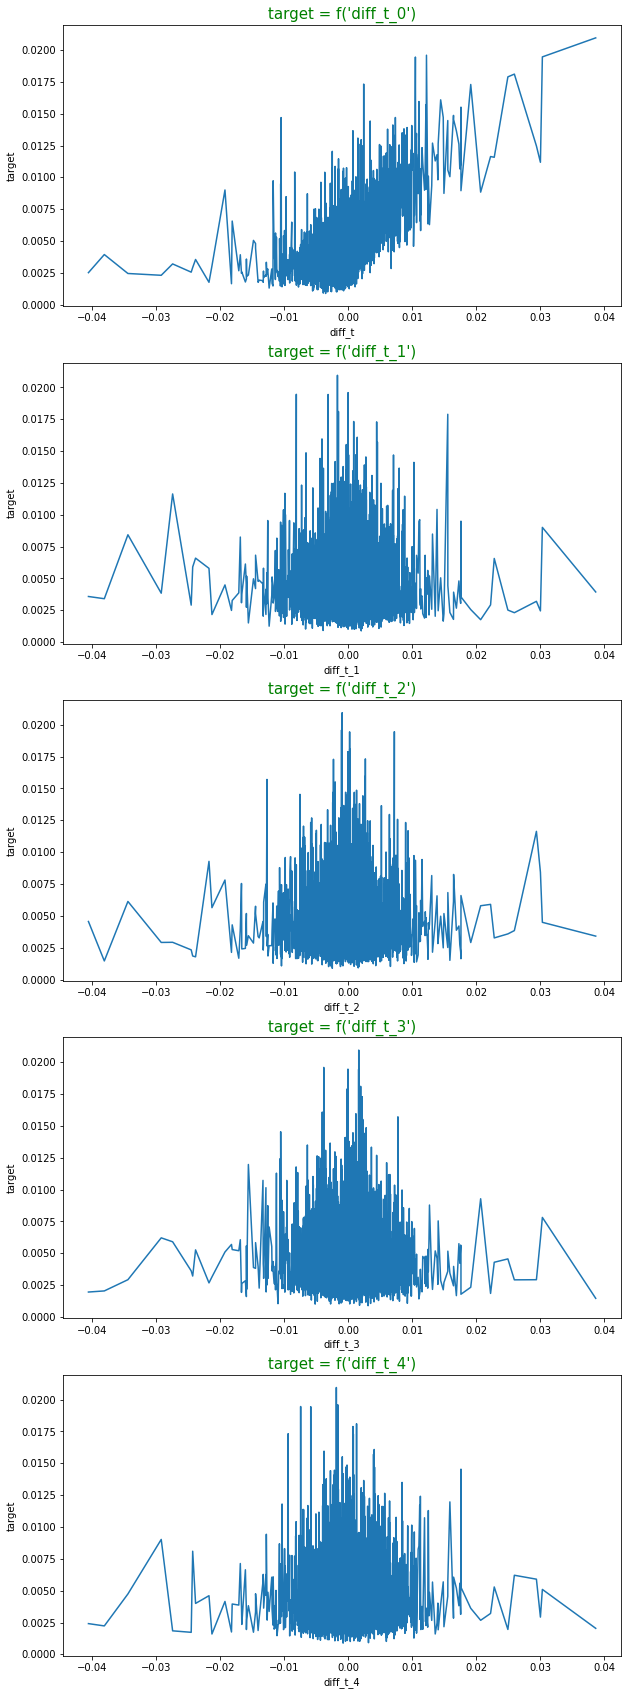

In [82]:
fig,ax = plt.subplots(5,1,figsize=(10,30))
for i in range(5) :
    if i == 0 : 
       sns.lineplot(data_stock_id_1["diff_t"],data_stock_id_1["target"],ax=ax[i])
    else :
       sns.lineplot(data_stock_id_1[f"diff_t_{i}"],data_stock_id_1["target"],ax=ax[i])
    ax[i].set_title(f"target = f('diff_t_{i}')",size=15,color="green")

In [83]:
table_correlation = pd.DataFrame({f"diff_t_{i}":data_stock_id_1["target"].\
                                  corr(data_stock_id_1[f"diff_t_{i}"]) for i in range(1,5)},index=["target"])
table_correlation["diff_t"] = data_stock_id_1["target"].corr(data_stock_id_1["diff_t"])

<AxesSubplot:>

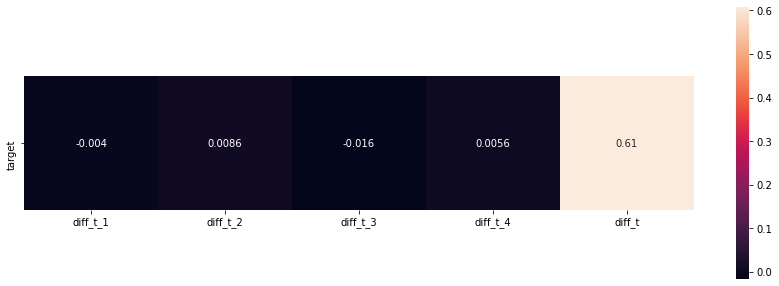

In [84]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.heatmap(table_correlation,annot=True,square=True)

> The above analysis shows a high positive correlation , between diff_t and the target feature. Besides , the chart above show also a quadratic relation between diff_t_i and target features for i in {1,2,3,4}

In [85]:
# study quadratic relation between realized_t_i features for i in {1,2,3,4,5} and target feature.
for i in range(1,6):
    data_stock_id_1[f"realized_t_{i}^2"] = data_stock_id_1[f"realized_t_{i}"] ** 2

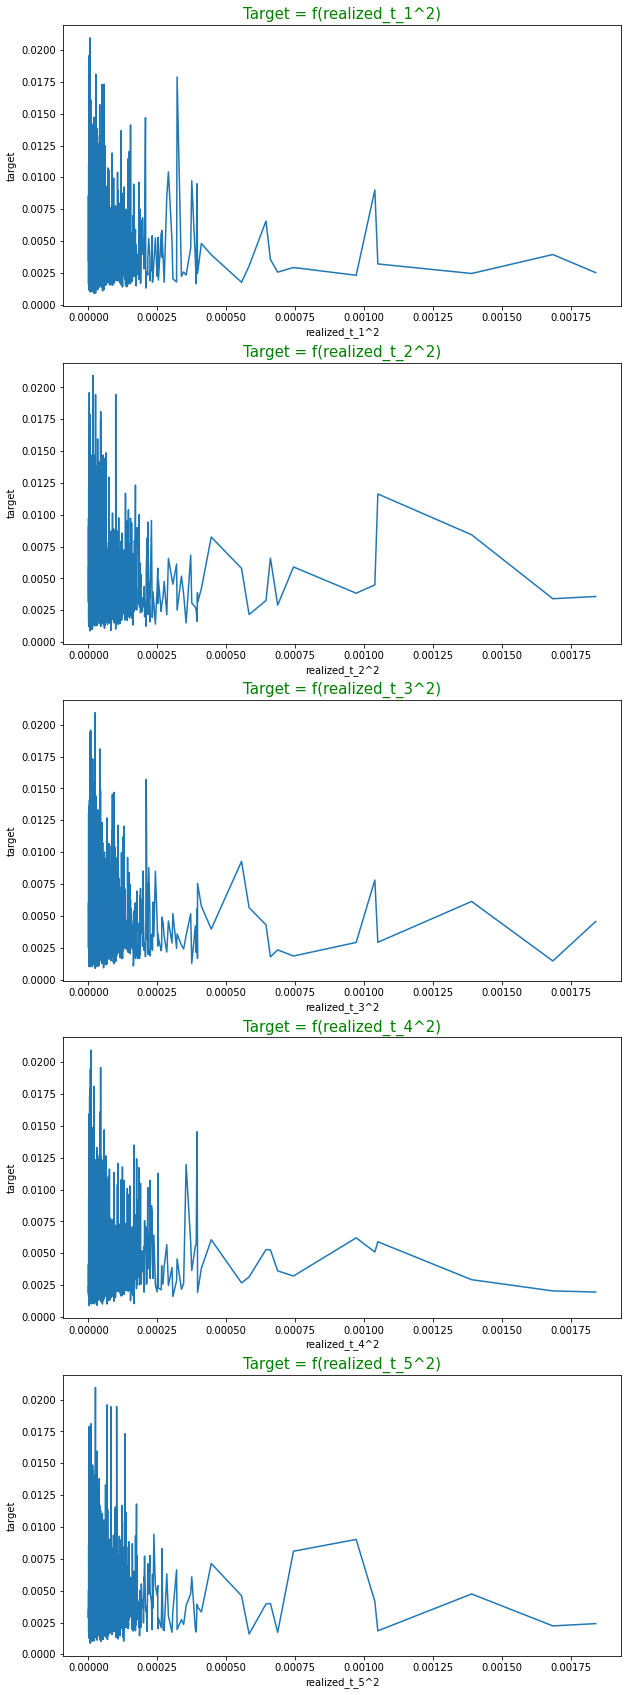

In [86]:
fig,ax = plt.subplots(5,1,figsize=(10,30))
for i in range(1,6) :
    sns.lineplot(data_stock_id_1[f"realized_t_{i}^2"],data_stock_id_1["target"],ax=ax[i-1])
    ax[i-1].set_title(f"Target = f(realized_t_{i}^2)",size=15,color="green")

In [87]:
table_correlation = pd.DataFrame({f"realized_t_{i}^2": data_stock_id_1["target"].corr(data_stock_id_1[f"realized_t_{i}^2"])\
                                                                                      for i in range(1,6)},index=["target"])

<AxesSubplot:>

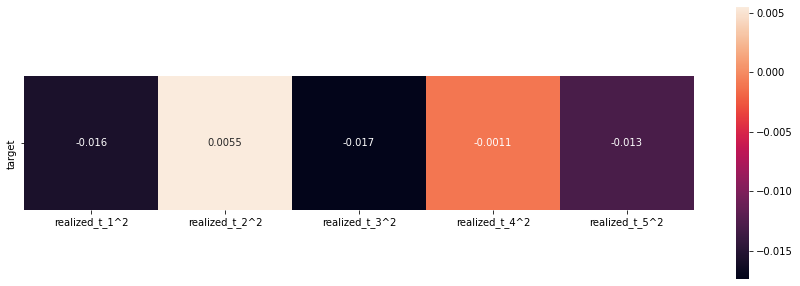

In [88]:
fig = plt.figure(figsize=(15,5))
sns.heatmap(table_correlation,annot=True,square=True)

==> No correlation shown between quadratic realized_t_i features and target feature  for i in{1,2,3,4,5}.

In [89]:
# Study correlation between target feature and diff_t_i features for i in {1,2,3,4}.
for i in range(1,5) : 
    data_stock_id_1[f"diff_t_{i}^2"] = data_stock_id_1[f"diff_t_{i}"] ** 2

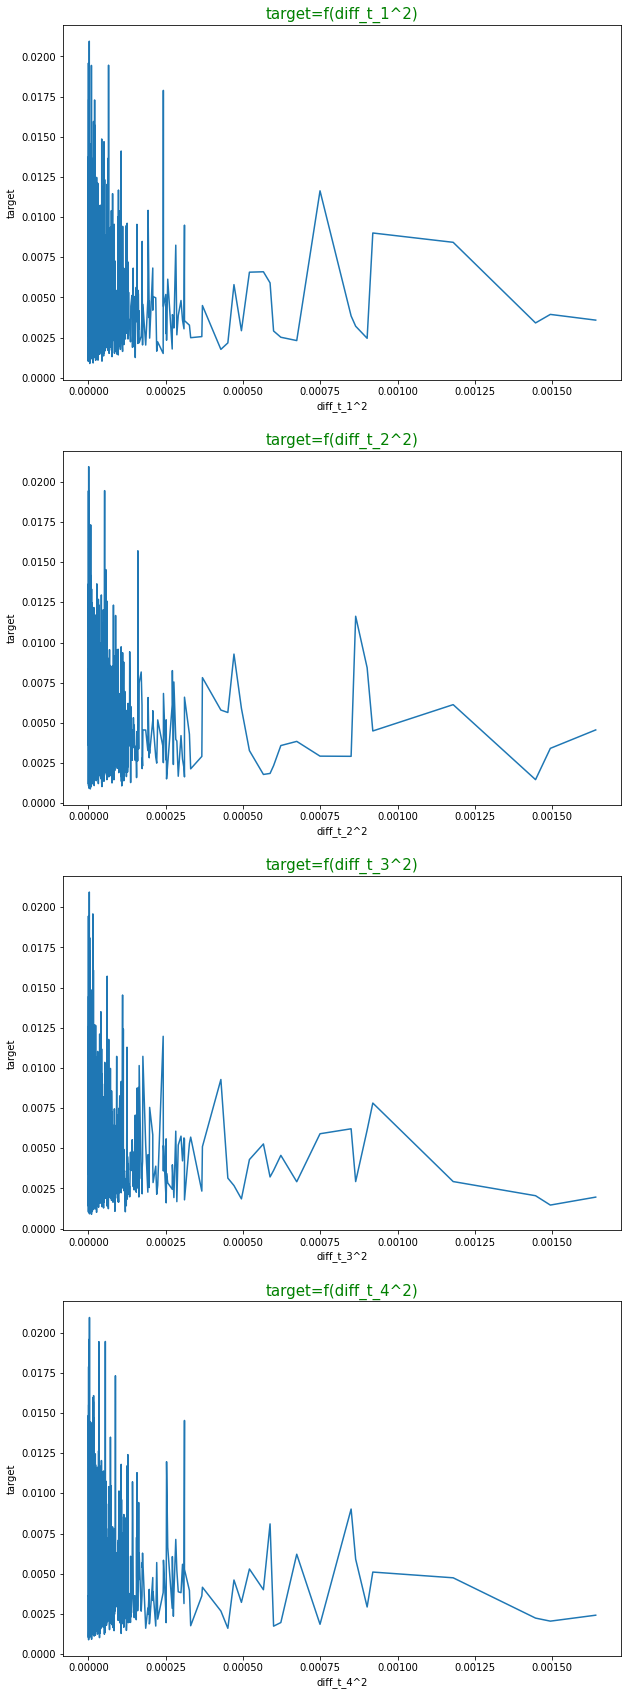

In [90]:
fig,ax = plt.subplots(4,1,figsize=(10,30))
for i in range(1,5) :
    sns.lineplot(data_stock_id_1[f"diff_t_{i}^2"],data_stock_id_1["target"],ax=ax[i-1])
    ax[i-1].set_title(f"target=f(diff_t_{i}^2)",size=15,color="green")

In [91]:
table_correlation = pd.DataFrame({f"diff_t_{i}^2":data_stock_id_1[f"diff_t_{i}^2"].\
                                  corr(data_stock_id_1["target"])for i in range(1,5)},index=\
                                ["target"])

<AxesSubplot:>

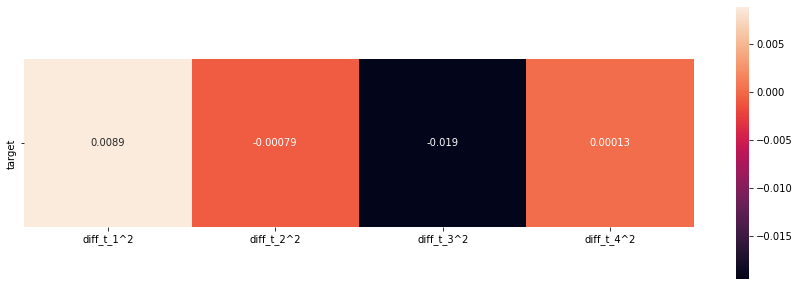

In [92]:
fig = plt.figure(figsize=(15,5))
sns.heatmap(table_correlation,annot=True,square=True)

> ==> No correlation showed between diff_t_i^2 features for i in {1,2,3,4} and target feature.

In [93]:
# Let's study correlation between the quadratic of realized_t feature, the quadratic of 
# diff_t feature and the target feature.
data_stock_id_1["realized_t^2"] = data_stock_id_1["realized_t"] ** 2
data_stock_id_1["diff_t^2"] = data_stock_id_1["diff_t"] ** 2

Text(0.5, 1.0, 'target=f(diff_t^2)')

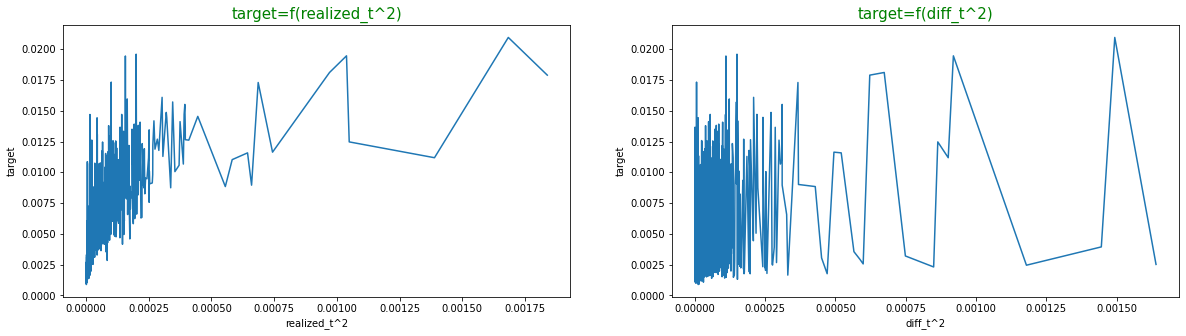

In [94]:
fig,ax = plt.subplots(1,2,figsize=(20,5))

sns.lineplot(data_stock_id_1["realized_t^2"],data_stock_id_1["target"],ax=ax[0])
ax[0].set_title("target=f(realized_t^2)",size=15,color="green")
sns.lineplot(data_stock_id_1["diff_t^2"],data_stock_id_1["target"],ax=ax[1])
ax[1].set_title("target=f(diff_t^2)",size=15,color="green")

In [95]:
table_correlation = pd.DataFrame({"realized_t^2":data_stock_id_1["realized_t^2"].\
                                  corr(data_stock_id_1["target"]),"diff_t^2":data_stock_id_1["diff_t^2"].corr(data_stock_id_1["target"])},\
                                index=["target"])

<AxesSubplot:>

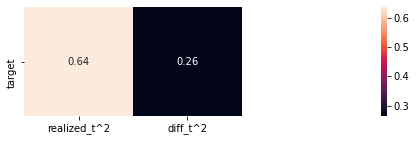

In [96]:
fig = plt.figure(figsize=(50,2))
sns.heatmap(table_correlation,annot=True,square=True)

> ==> very high positive correlation between realized_t^2 feature and target feature. We can also underline some positive correlation between diff_t^2 and target feature.

### Exploration and feature engineering related to realized1_t feature:

In [97]:
for i in range(1,6):
    data_stock_id_1[f"realized1_t_{i}"] = data_stock_id_1["realized1_t"].shift(i)

In [98]:
missing_realized1_t_1 = np.where(data_stock_id_1["realized1_t_1"].isna())[0]
missing_realized1_t_2 = np.where(data_stock_id_1["realized1_t_2"].isna())[0]
missing_realized1_t_3 = np.where(data_stock_id_1["realized1_t_3"].isna())[0]
missing_realized1_t_4 = np.where(data_stock_id_1["realized1_t_4"].isna())[0]
missing_realized1_t_5 = np.where(data_stock_id_1["realized1_t_5"].isna())[0]
for i in missing_realized_t_1 : 
    data_stock_id_1.loc[i,"realized1_t_1"] = data_stock_id_1.loc[i,"realized1_t"]
for i in missing_realized_t_2 : 
    data_stock_id_1.loc[i,"realized1_t_2"] = data_stock_id_1.loc[i,"realized1_t_1"]
for i in missing_realized_t_3 : 
    data_stock_id_1.loc[i,"realized1_t_3"] = data_stock_id_1.loc[i,"realized1_t_2"]
for i in missing_realized_t_4 : 
    data_stock_id_1.loc[i,"realized1_t_4"] = data_stock_id_1.loc[i,"realized1_t_3"]
for i in missing_realized_t_5 : 
    data_stock_id_1.loc[i,"realized1_t_5"] = data_stock_id_1.loc[i,"realized1_t_4"]

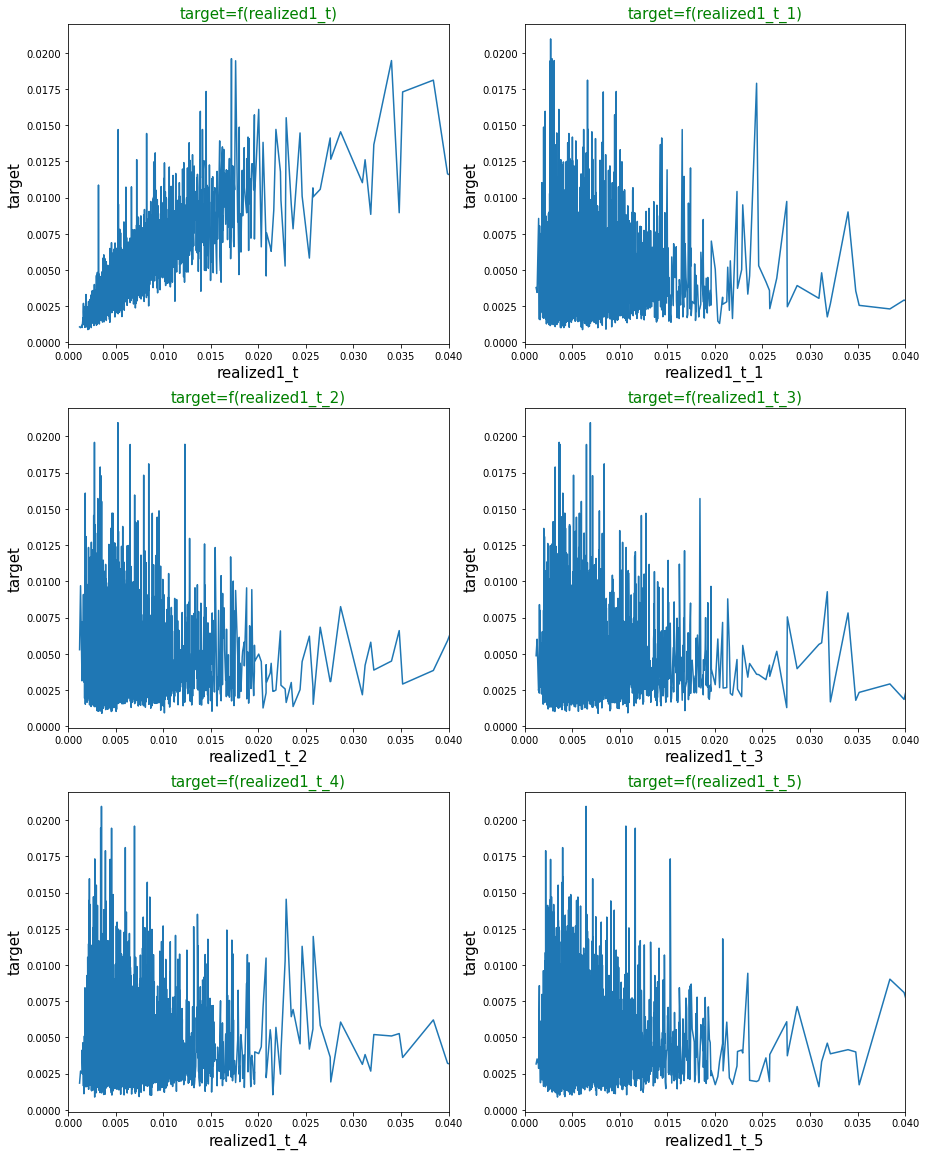

In [99]:
fix,axes = plt.subplots(3,2,figsize=(15,20))
for i in range(6) :
    if i != 0 :
       sns.lineplot(data_stock_id_1.loc[:,f"realized1_t_{i}"].values,data_stock_id_1.loc[:,"target"].\
                 values,ax=axes[i//2,i%2])
       axes[i//2,i%2].set_xlabel(f"realized1_t_{i}",size=15)
       axes[i//2,i%2].set_ylabel("target",size=15)
       axes[i//2,i%2].set_title(f"target=f(realized1_t_{i})",size=15,color="green")
       axes[i//2,i%2].set_xlim([0,0.04])
    else : 
       sns.lineplot(data_stock_id_1.loc[:,"realized1_t"].values,data_stock_id_1.loc[:,"target"].\
                 values,ax=axes[i//2,i%2])
       axes[i//2,i%2].set_xlabel("realized1_t",size=15)
       axes[i//2,i%2].set_ylabel("target",size=15)
       axes[i//2,i%2].set_xlim([0,0.04])
       axes[i//2,i%2].set_title("target=f(realized1_t)",size=15,color="green")

In [100]:
table_correlation = pd.DataFrame({f"realized1_t_{i}":data_stock_id_1["target"].\
                                  corr(data_stock_id_1[f"realized1_t_{i}"]) for i in range(1,6)},index=["target"])
table_correlation["realized1_t"] = data_stock_id_1["target"].corr(data_stock_id_1["realized1_t"])

<AxesSubplot:>

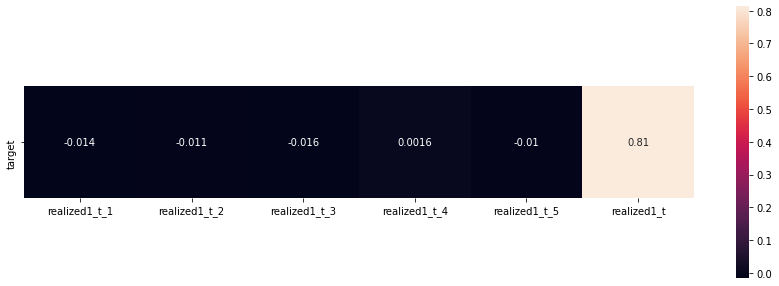

In [101]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.heatmap(table_correlation,annot=True,square=True)

> ==> High positive correlation between realized volatility for second price in time t with target of time t.Moreover, we don't find any correlation between realized volatility for second price of previous times and the current target.

In [102]:
data_stock_id_1.loc[:,"diff1_t"] = data_stock_id_1.loc[:,"realized1_t"] - data_stock_id_1.loc[:,"realized1_t_1"]
data_stock_id_1.loc[:,"realized1_t^2"] = data_stock_id_1.loc[:,"realized1_t"] ** 2
data_stock_id_1.loc[:,"diff1_t^2"] = data_stock_id_1.loc[:,"diff1_t"] ** 2

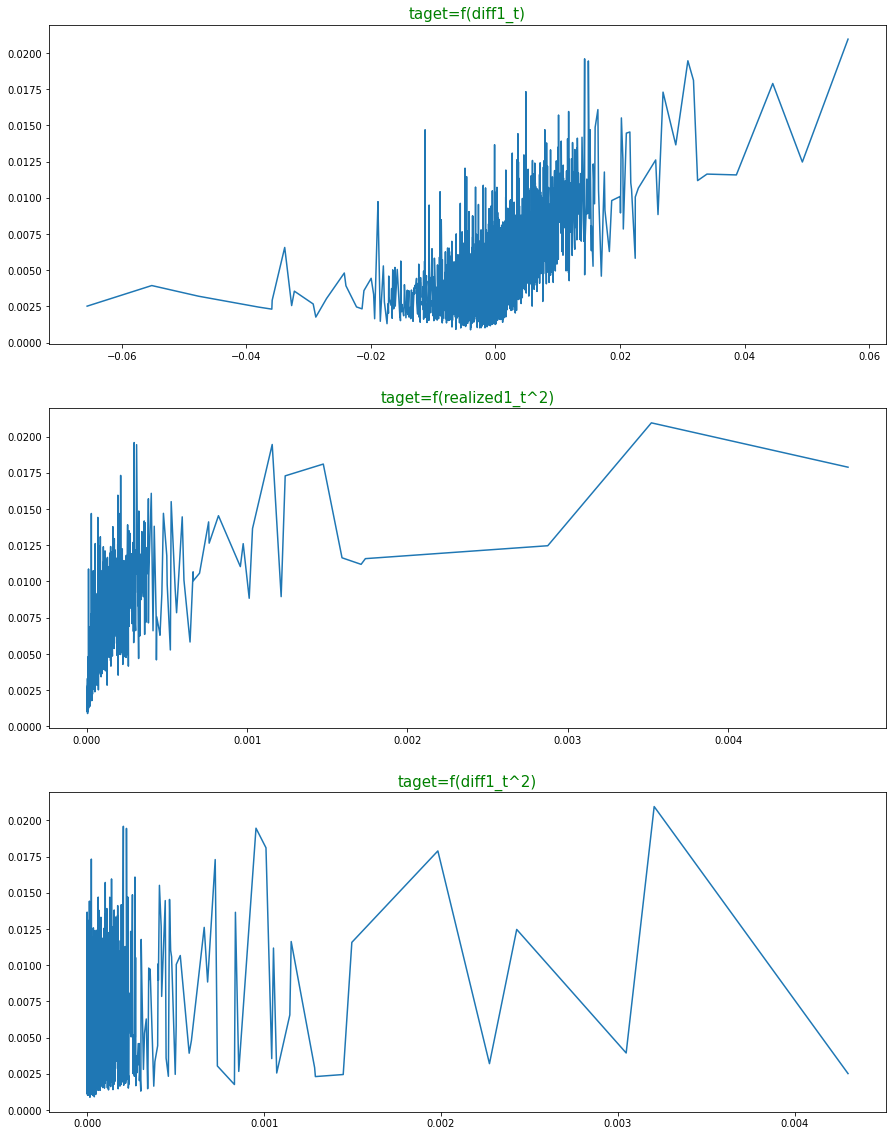

In [103]:
features = ["diff1_t","realized1_t^2","diff1_t^2"]
fig,ax = plt.subplots(3,1,figsize=(15,20))
for i in range(3) :
    sns.lineplot(data_stock_id_1.loc[:,f"{features[i]}"].values,data_stock_id_1.loc[:,"target"].values,\
                ax=ax[i])
    ax[i].set_title(f"taget=f({features[i]})",size=15,color="green")

In [104]:
table_correlation = pd.DataFrame({features[i]:data_stock_id_1["target"].corr(data_stock_id_1[features[i]])\
                                 for i in range(3)},index=["target"])

<AxesSubplot:>

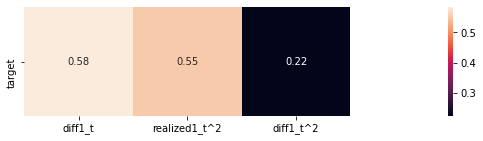

In [105]:
fig = plt.figure(figsize=(35,2))
sns.heatmap(table_correlation,annot=True,square=True)

> ==> The chart above shows a respectful positive correlation between diff1_t and realized1_t^2 features with the target feature. We can also,see very slim positive correlation of target feature with diff1_t^2 feature.

### Exploration and feature engineering related to supply_demand_volatility feature:

In [106]:
data_stock_id_1["supply_demand_1"] = data_stock_id_1["supply_demand_volatilty"].shift(1)

In [107]:
ind = np.where(data_stock_id_1["supply_demand_1"].isna())[0]
for i in ind :
    data_stock_id_1.loc[i,"supply_demand_1"] = data_stock_id_1.loc[i,"supply_demand_volatilty"]

In [108]:
data_stock_id_1["diff_supply_demand"] = data_stock_id_1["supply_demand_volatilty"]-data_stock_id_1[\
                                                                                                  "supply_demand_1"]

In [109]:
supply_features = ["supply_demand_volatilty","supply_demand_1","diff_supply_demand",\
                   "supply_demand_mean"]

In [110]:
table_correlation = pd.DataFrame({f:data_stock_id_1[f].corr(data_stock_id_1["target"]) for \
                                 f in supply_features},index=["target"])

<AxesSubplot:>

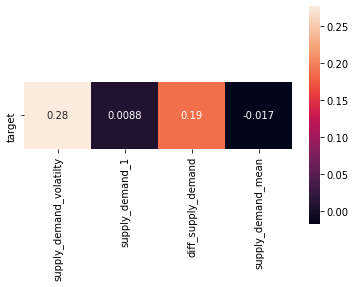

In [111]:
sns.heatmap(table_correlation,annot=True,square=True)

> ==> very slim correlation between target feature and the features supply_demand_volatilty and diff_supply_demand features.

### Exploration and feature engineering related to others features:

In [112]:
others_features = ["realized_squared_volatility","realized_diff_bid_price","realized_diff_ask_price",\
                  "diff_bid_price_mean","diff_ask_price_mean",'log_wap3_realized_volatility','wap_balance_mean',\
                  'price_spread_mean','volume_imbalance_mean','total_volume_mean','wap_mean',\
                  'log_avg_wap_realized_volatility','price_spread_1_mean','price_spread_avg_mean',\
                   'price_spread_diff_mean','log_wap_balance_realized_volatility',
       'log_price_spread_realized_volatility',
       'log_price_spread_1_realized_volatility',
       'log_price_spread_avg_realized_volatility',
       'log_price_spread_diff_realized_volatility',
       'log_volume_imbalance_realized_volatility', 'bid_size_sum',
       'ask_size_sum']
table_correlation = pd.DataFrame({f:data_stock_id_1[f].corr(data_stock_id_1["target"]) for f in others_features},\
                                index=["target"])

<AxesSubplot:>

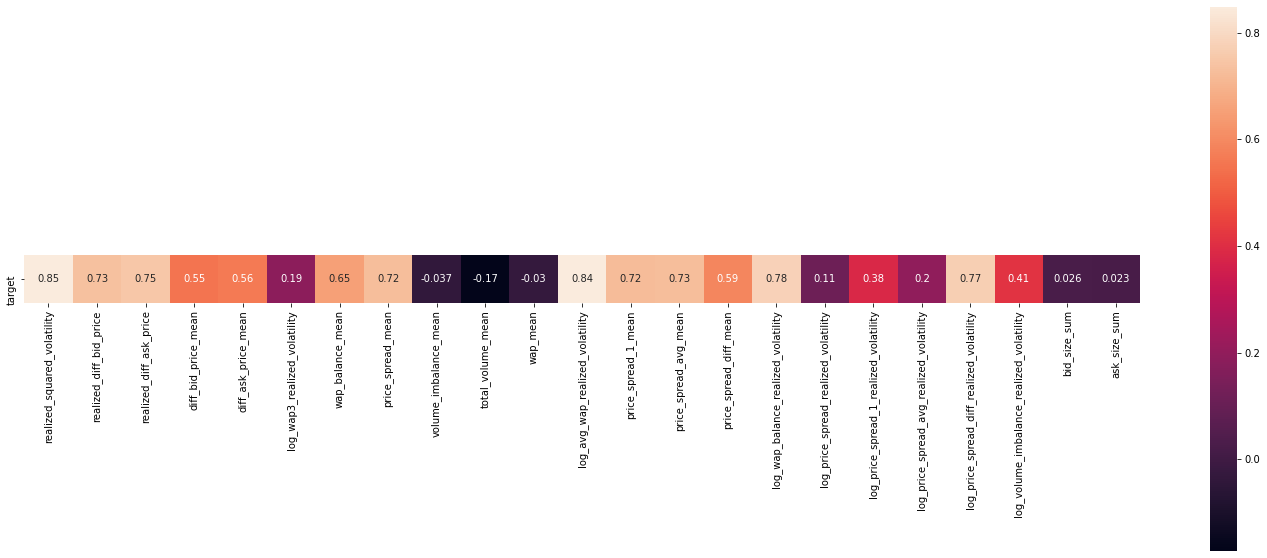

In [113]:
fig = plt.figure(figsize=(25,10))
sns.heatmap(table_correlation,annot=True,square=True)

> ==> high correlation between realized_squared_volatility feature and target feature.

## Trade features explorations :

In [114]:
trade_train_stock_id_1["log_price"] = trade_train_stock_id_1.groupby("time_id")["price"].\
apply(log_return)

In [115]:
trade_train_stock_id_1["size_order"] = trade_train_stock_id_1["size"]/trade_train_stock_id_1["order_count"]


In [116]:
trade_train_stock_id_1 = trade_train_stock_id_1.loc[~(trade_train_stock_id_1.loc[:,"log_price"].isnull())]

In [117]:
aggregate_dictionary={
    "price" : [np.mean],
    "log_price" : [realized_volatility],
    "size_order" : [np.mean],
    "size" : [np.mean,np.sum,np.std],
    "order_count" : [np.sum],
    "seconds_in_bucket":[count_unique],
    "order_count":[np.sum,np.std,np.mean]
}

In [118]:
stock_features = trade_train_stock_id_1.groupby("time_id").agg(aggregate_dictionary).reset_index()

In [119]:
stock_features.columns = ["_".join(col) for col in stock_features]

In [120]:
stock_features.rename(columns={"log_price_realized_volatility":"vol_price"},inplace=True)

In [121]:
stock_features.rename(columns={"time_id_":"time_id"},inplace=True)

In [122]:
data_stock_id_1 = data_stock_id_1.merge(stock_features,how="left",on="time_id")

In [123]:
data_stock_id_1["vol_price_1"] = data_stock_id_1["vol_price"].shift()

In [124]:
indices = np.where(data_stock_id_1["vol_price_1"].isna())[0]

for i in indices :
    data_stock_id_1.loc[i,"vol_price_1"] =  data_stock_id_1.loc[i,"vol_price"] 

In [125]:
data_stock_id_1["diff_price"] = data_stock_id_1["vol_price_1"] - data_stock_id_1["vol_price"]

In [126]:
data_stock_id_1["vol_price^2"] = data_stock_id_1["vol_price"] ** 2

In [127]:
data_stock_id_1["balance_wap_price"] = abs(data_stock_id_1["price_mean"]- \
                                           data_stock_id_1["wap_mean"])

In [128]:
data_stock_id_1["rapp_price"] = (data_stock_id_1["price_mean"]+1)/(data_stock_id_1["wap_mean"]+1)

In [129]:
data_stock_id_1["shares_vs_bid"] = data_stock_id_1["size_sum"] - data_stock_id_1["bid_size_sum"]

In [130]:
data_stock_id_1["shares_vs_ask"] = data_stock_id_1["size_sum"] - data_stock_id_1["ask_size_sum"]

In [131]:
f = list(stock_features.columns[1:]) + ["vol_price_1","diff_price","vol_price^2",\
                                        "balance_wap_price","rapp_price","shares_vs_bid",\
                                       "shares_vs_ask"]

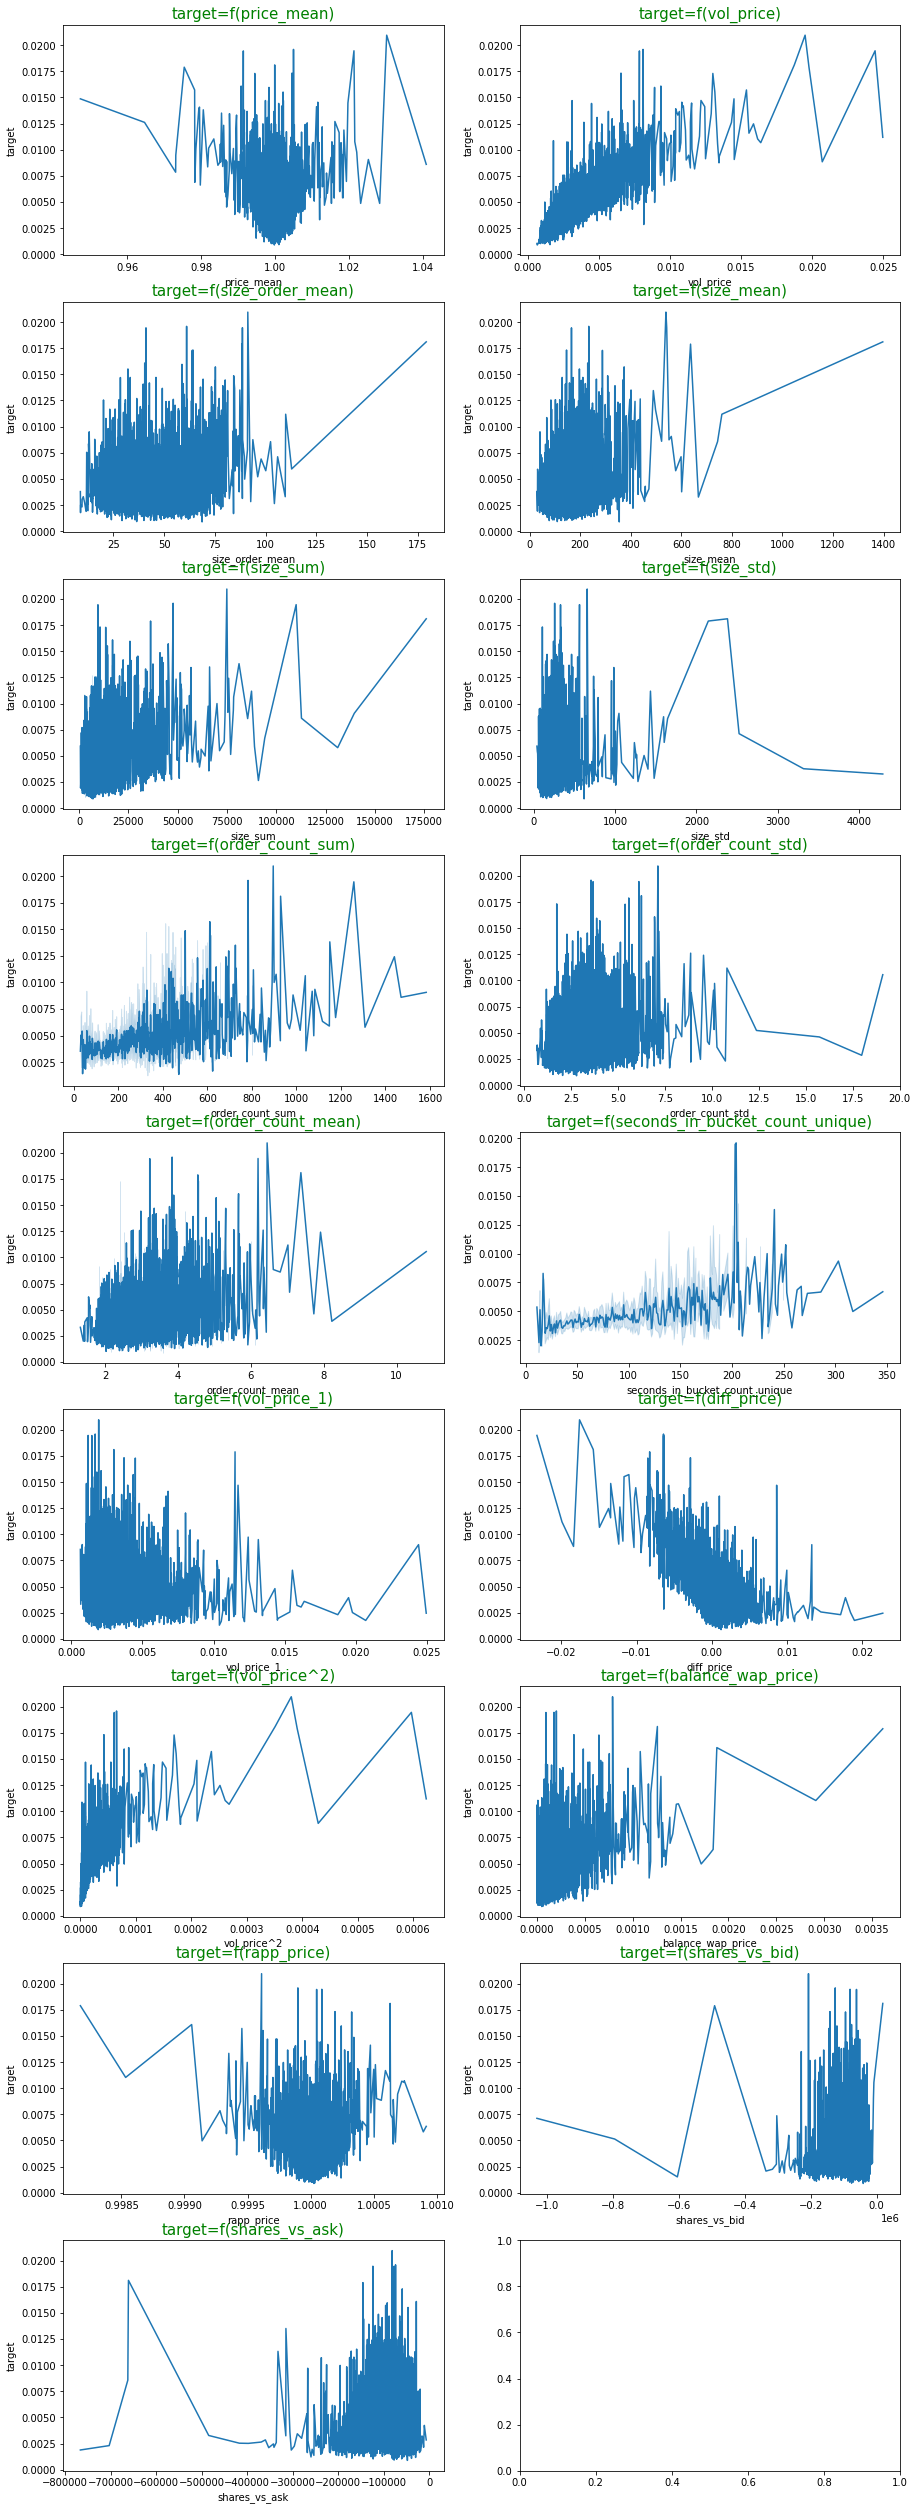

In [132]:
fig,ax = plt.subplots(math.ceil(len(f)/2),2,figsize=(15,45))
for i in range(len(f)) :
    sns.lineplot(data_stock_id_1[f[i]],data_stock_id_1["target"],ax=ax[i//2,i%2])
    ax[i//2,i%2].set_title(f"target=f({f[i]})",size=15,color="green")

In [133]:
table_correlation = pd.DataFrame({f[i]:data_stock_id_1[f[i]].corr(data_stock_id_1["target"]) for i in range(len(f))},\
                                index=["target"])

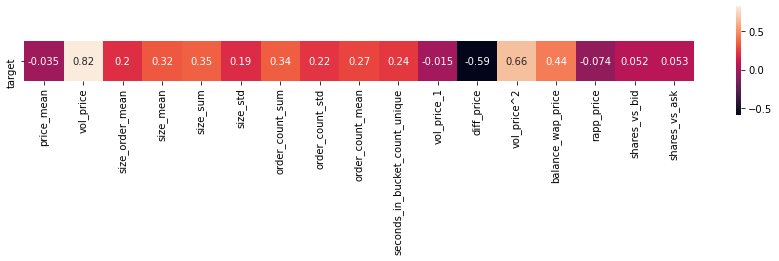

In [134]:
fig = plt.figure(figsize=(15,2))
sns.heatmap(table_correlation,annot=True,square=True)
plt.show()

> ===> We can notice from the chart above , that there is high correlation between target feature and vol_price feature, besides we notice also a positive correaltion between vol_price^2 feature and target feature , and a negative correlation between diff_price feature and target feature.

## Top insights :
- High positive correlation between realized squared volatility and target feature.
- High positive correlation between vol_price feature and target feature.
- High positive correlation between realized_t feature and target feature.
- Positive correlation between vol_price^2 feature and target feature.
- negative correlation between diff_price feature and target feature.
- Positive correlation between diff_t feature and target feature.
- Positive correlation between realized_t^2 feature and target feature.
- High positive correlation between realized1_t feature and target feature.  
- Positive correlation between diff1_t feature and target feature.
- Positive correlation between realized1_t^2 feature and target feature.

# 4.Preprocessing datas :

In [135]:
def preprocessing_stock_id_time_id(st_file):
    book_train_stock_id = pd.read_parquet(st_file)
    stock_id = st_file.split("=")[1]
    book_train_stock_id["stock_id"] = stock_id 
    book_train_stock_id["wap"] = (book_train_stock_id['bid_price1'] * book_train_stock_id['ask_size1']+book_train_stock_id['ask_price1'] * book_train_stock_id['bid_size1'])  / (
                                      book_train_stock_id['bid_size1']+ book_train_stock_id[
                                  'ask_size1'])
    book_train_stock_id["wap1"] = (book_train_stock_id['bid_price2'] * book_train_stock_id['ask_size2']+book_train_stock_id['ask_price2'] * book_train_stock_id['bid_size2'])  / (
                                      book_train_stock_id['bid_size2']+ book_train_stock_id[
                                  'ask_size2'])
    book_train_stock_id["supply_demand"] = (book_train_stock_id["ask_size1"]+book_train_stock_id["ask_size2"])/(book_train_stock_id["bid_size1"]+book_train_stock_id["bid_size2"])
    book_train_stock_id["squared_wap"] = book_train_stock_id["wap"] ** 2
    book_train_stock_id["squared_wap_1"] = book_train_stock_id["wap1"] ** 2
    
    book_train_stock_id["log_supply_demand"] = book_train_stock_id.groupby("time_id")["supply_demand"].apply(log_return)
    book_train_stock_id["log_return"] = book_train_stock_id.groupby("time_id")["wap"].apply(log_return)
    book_train_stock_id["log_return1"] = book_train_stock_id.groupby("time_id")["wap1"].apply(log_return)
    book_train_stock_id["log_squared_wap"] = book_train_stock_id.groupby("time_id")["squared_wap"].apply(log_return)
    book_train_stock_id["log_squared_wap_1"] = book_train_stock_id.groupby("time_id")["squared_wap_1"].apply(log_return)
    
    book_train_stock_id["diff_bid_price"] = book_train_stock_id["bid_price1"] - book_train_stock_id["bid_price2"]
    book_train_stock_id["diff_ask_price"] = book_train_stock_id["ask_price2"] - book_train_stock_id["ask_price1"]
    
    book_train_stock_id["log_diff_bid_price"] = book_train_stock_id.groupby("time_id")["diff_bid_price"].apply(log_return)
    book_train_stock_id["log_diff_ask_price"] = book_train_stock_id.groupby("time_id")["diff_ask_price"].apply(log_return)
    
    
    book_train_stock_id["wap3"] =  (book_train_stock_id['bid_price1'] * book_train_stock_id['bid_size1']+book_train_stock_id['ask_price1'] * book_train_stock_id['ask_size1'])  / (
                                      book_train_stock_id['ask_size1']+ book_train_stock_id[
                                  'bid_size1'])
    book_train_stock_id["log_wap3"] = book_train_stock_id.groupby("time_id")["wap3"].apply(log_return)
    
    
    book_train_stock_id["wap_balance"] = abs(book_train_stock_id["wap"] - book_train_stock_id["wap1"])
    book_train_stock_id["price_spread"] = book_train_stock_id["ask_price1"] - book_train_stock_id["bid_price1"]
    book_train_stock_id["price_spread_1"] = book_train_stock_id["ask_price2"] - \
book_train_stock_id_1["bid_price2"]
    book_train_stock_id["total_volume"] = book_train_stock_id["ask_size1"]+\
book_train_stock_id["bid_size1"] + book_train_stock_id["ask_size2"] +\
book_train_stock_id["bid_size2"]
    
    book_train_stock_id.loc[:,"avg_wap"] = book_train_stock_id.loc[:,"wap"] + \
book_train_stock_id.loc[:,"wap1"]/2
    book_train_stock_id["log_avg_wap"] = book_train_stock_id.groupby("time_id")["avg_wap"].apply(log_return)
    book_train_stock_id["price_spread_avg"] = book_train_stock_id["price_spread"] + \
book_train_stock_id["price_spread_1"] /2
    book_train_stock_id["price_spread_diff"] = book_train_stock_id["price_spread_1"] - \
book_train_stock_id["price_spread"]
    
    book_train_stock_id["wap_balance"] = abs(book_train_stock_id["wap"]-\
                                           book_train_stock_id["wap1"])+1
    
    book_train_stock_id["log_wap_balance"] = book_train_stock_id.groupby("time_id")["wap_balance"]\
.apply(log_return)
    book_train_stock_id["log_price_spread"] = book_train_stock_id.groupby("time_id")["price_spread"]\
.apply(log_return)
    book_train_stock_id["log_price_spread_1"] = book_train_stock_id.groupby("time_id")["price_spread_1"].\
apply(log_return)
    book_train_stock_id["log_avg_wap"] = book_train_stock_id.groupby("time_id")["avg_wap"].apply(log_return)
    book_train_stock_id["log_price_spread_avg"] = book_train_stock_id.groupby("time_id")["price_spread_avg"].\
    apply(log_return)
    book_train_stock_id["log_price_spread_diff"] = book_train_stock_id.groupby("time_id")["price_spread_diff"].\
apply(log_return)
    book_train_stock_id["volume_imbalance"] = (book_train_stock_id["bid_size1"] +\
book_train_stock_id["bid_size2"]) - (book_train_stock_id["ask_size1"]+\
                                       book_train_stock_id["ask_size2"])
    book_train_stock_id["volume_imbalance"] = 1 + book_train_stock_id["volume_imbalance"].abs()
    book_train_stock_id["log_volume_imbalance"] = book_train_stock_id.groupby("time_id")["volume_imbalance"]\
.apply(log_return)
    book_train_stock_id["bid_size"] = book_train_stock_id["bid_size1"] + book_train_stock_id["bid_size2"]
    book_train_stock_id["ask_size"] = book_train_stock_id["ask_size1"] + book_train_stock_id["ask_size2"]
    book_train_stock_id = book_train_stock_id.loc[~((book_train_stock_id["log_return"].isnull())|\
                                                  (book_train_stock_id["log_return1"].isnull())|(\
                                                    book_train_stock_id["log_supply_demand"].isnull())),:]
    
    create_feature_dict = { 'log_return':[realized_volatility],
        'log_return1':[realized_volatility],
        'log_squared_wap':[realized_volatility],
        'log_squared_wap_1':[realized_volatility],                
        "log_supply_demand":[realized_volatility],
        "diff_bid_price":[np.mean],
        "diff_ask_price":[np.mean],
        "log_diff_ask_price":[realized_volatility],
        "log_diff_bid_price" :[realized_volatility],
        "log_wap3":[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        #'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
        "log_avg_wap" :[realized_volatility],
        "price_spread_1":[np.mean],
        "price_spread_avg":[np.mean],
        "price_spread_diff":[np.mean],
        "log_wap_balance":[realized_volatility],
        "log_price_spread":[realized_volatility],
        "log_price_spread_1":[realized_volatility],
        "log_price_spread_avg":[realized_volatility],
        "log_price_spread_diff":[realized_volatility],
        "log_volume_imbalance":[realized_volatility],
        "bid_size":[np.sum],
        "ask_size":[np.sum]
    }
    book_features = book_train_stock_id.groupby("time_id").agg( create_feature_dict).reset_index()
    book_features.columns = ["_".join(col) for col in book_features]
    book_features.rename(columns={"time_id_":"time_id"},inplace=True)
    
    book_features.rename(columns={"log_return_realized_volatility":"realized_volatility",\
                               "log_return1_realized_volatility":"realized_volatility1",\
                               "log_squared_wap_realized_volatility":"squared_wap_vol",\
                               "log_supply_demand_realized_volatility":"realized_supply_demand",\
                               "log_diff_ask_price_realized_volatility":"realized_ask_price",\
                               "log_diff_bid_price_realized_volatility":"realized_bid_price",\
                                "log_squared_wap_1_realized_volatility":"squared_wap1_vol",\
                                "log_wap_balance":[realized_volatility]},inplace=True)
    book_features["row_id"] = book_features["time_id"].map(lambda x :f"{stock_id}-{x}")
        
    return book_features

In [136]:
def preprocessing_all_files (all_files):
    df = pd.DataFrame()
    
    for file in all_files :
        df= pd.concat([df,preprocessing_stock_id_time_id(file)])
        #dff = pd.concat([dff,preprocessing_stock_id_time_id(file)[1]])
    return df 

In [137]:
all_files = glob.glob("../input/optiver-realized-volatility-prediction/book_train.parquet/*")

In [138]:
data_train_episodes = preprocessing_all_files(all_files)

In [139]:
def preprocessing_trade_stock_time_id(file):
    trade_id = pd.read_parquet(file)
    trade_id["log_price"] = trade_id.groupby("time_id")["price"].apply(log_return)
    trade_id = trade_id.loc[~(trade_id.loc[:,"log_price"].isnull()),:]
    trade_id["size_order"] = trade_id["size"]/trade_id["order_count"]
    aggregate_dictionary={
    "price" : [np.mean],
    "log_price" : [realized_volatility],
    "size_order" : [np.mean],
    "size" : [np.mean,np.sum,np.std],
    "order_count" : [np.sum],
    "seconds_in_bucket":[count_unique],
    "order_count":[np.sum,np.std,np.mean]
    }
    df = trade_id.groupby("time_id").agg(aggregate_dictionary)
    df = df.reset_index(drop=False)
    df.columns = ["_".join(col) for col in df]
    df.rename(columns={"log_price_realized_volatility":"vol_price"},inplace=True)
    df.rename(columns={"time_id_":"time_id"},inplace=True)
    
    df["stock_id"] = file.split("=")[1]
    df["row_id"] = df["time_id"].apply(lambda x : f"{file.split('=')[1]}-{x}")
    
    return df
    

In [140]:
def preprocessing_trade_all_file(files):
    df = pd.DataFrame()
    for f in files :
        df = pd.concat([df,preprocessing_trade_stock_time_id(f)])
    return df 

In [141]:
files = glob.glob("../input/optiver-realized-volatility-prediction/trade_train.parquet/*")

In [142]:
trade_stock = preprocessing_trade_all_file(files)

In [143]:
def merge_and_create_feature_engineering(labeled_df,data_episodes):
    
    labeled_df["row_id"] = labeled_df["stock_id"].astype(str).str.cat(labeled_df["time_id"].\
                                                                     astype(str),sep="-")
    del(labeled_df["time_id"])
    #del(labeled_df["stock_id"])
    comb_data = labeled_df.merge(data_episodes,on="row_id",how="left")
    comb_data.rename(columns={"realized_volatility":"realized_t"},inplace=True)
    comb_data["realized_t_1"] = comb_data.groupby("stock_id")["realized_t"].shift(1)
    index = np.where(comb_data["realized_t_1"].isna())[0]
    for i in index :
        comb_data.loc[i,"realized_t_1"] = comb_data.loc[i,"realized_t"]
    comb_data.loc[:,"diff_t"] = comb_data.loc[:,"realized_t"] - comb_data.loc[:,"realized_t_1"]
    comb_data.drop("realized_t_1",axis=1,inplace=True)
    comb_data.loc[:,"diff_t^2"] = comb_data.loc[:,"diff_t"] ** 2
    comb_data.loc[:,"realized_t^2"] = comb_data.loc[:,"realized_t"] ** 2
   
    return comb_data

In [144]:
train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")

In [145]:
train_df = merge_and_create_feature_engineering(train,data_train_episodes)

In [146]:
def merge_and_create_feature_engineering_for_second_level(labeled_df):
    #labeled_df["row_id"] = labeled_df["stock_id"].astype(str).str.cat(labeled_df["time_id"].\
                                                                     #astype(str),sep="-")
    #comb_data = labeled_df.merge(data_episodes,on="row_id",how="right")
    comb_data = labeled_df
    comb_data.rename(columns={"realized_volatility1":"realized1_t"},inplace=True)
    comb_data["realized1_t_1"] = comb_data.groupby("stock_id")["realized1_t"].shift(1)
    index = np.where(comb_data["realized1_t_1"].isna())[0]
    for i in index :
        comb_data.loc[i,"realized1_t_1"] = comb_data.loc[i,"realized1_t"]
    comb_data.loc[:,"diff1_t"] = comb_data.loc[:,"realized1_t"] - comb_data.loc[:,"realized1_t_1"]
    comb_data.drop("realized1_t_1",axis=1,inplace=True)
    comb_data.loc[:,"diff1_t^2"] = comb_data.loc[:,"diff1_t"] ** 2
    comb_data.loc[:,"realized1_t^2"] = comb_data.loc[:,"realized1_t"] ** 2
    return comb_data

In [147]:
train_df = merge_and_create_feature_engineering_for_second_level(train_df)

In [148]:
train_df = train_df.merge(trade_stock,how="inner",on="row_id")

In [149]:
train_df["vol_price^2"] = train_df["vol_price"] ** 2

In [150]:
del(train_df['stock_id_y'])
del(train_df['time_id_y'])

In [151]:
train_df.rename(columns={"stock_id_x":"stock_id","time_id_x":"time_id"},inplace=True)

In [152]:
train_df["vol_price_1"] = train_df.groupby("stock_id")["vol_price"].shift(1)
ind = np.where(train_df["vol_price_1"].isna())[0]
for i in ind :
    train_df.loc[i,"vol_price_1"] = train_df.loc[i,"vol_price"]

In [153]:
train_df["diff_price"] = train_df["vol_price"] - train_df["vol_price_1"]
del(train_df["vol_price_1"])

In [154]:
train_df["balance_wap_price"] = abs(train_df["price_mean"]- \
                                           train_df["wap_mean"])

In [155]:
train_df.columns

Index(['stock_id', 'target', 'row_id', 'time_id', 'realized_t', 'realized1_t',
       'squared_wap_vol', 'squared_wap1_vol', 'realized_supply_demand',
       'diff_bid_price_mean', 'diff_ask_price_mean', 'realized_ask_price',
       'realized_bid_price', 'log_wap3_realized_volatility',
       'wap_balance_mean', 'price_spread_mean', 'total_volume_mean',
       'wap_mean', 'log_avg_wap_realized_volatility', 'price_spread_1_mean',
       'price_spread_avg_mean', 'price_spread_diff_mean',
       'log_wap_balance_realized_volatility',
       'log_price_spread_realized_volatility',
       'log_price_spread_1_realized_volatility',
       'log_price_spread_avg_realized_volatility',
       'log_price_spread_diff_realized_volatility',
       'log_volume_imbalance_realized_volatility', 'bid_size_sum',
       'ask_size_sum', 'diff_t', 'diff_t^2', 'realized_t^2', 'diff1_t',
       'diff1_t^2', 'realized1_t^2', 'price_mean', 'vol_price',
       'size_order_mean', 'size_mean', 'size_sum', 'size_std'

In [156]:
#retained_features = ["stock_id","realized_t","diff_t","realized_t^2","diff_t^2","realized1_t",\
                    #"diff1_t","diff1_t^2","realized1_t^2",'realized_supply_demand','squared_wap_vol',\
                     #'squared_wap1_vol',"vol_price","vol_price^2","diff_price","realized_bid_price","realized_ask_price"]
retained_features = [f for f in train_df.columns if f not in ("target","row_id","time_id")]

In [157]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# 5. Modeling :

### 5.1 LGBM :

In [158]:
def create_lgbm_model(X_train,Y_train,X_val,Y_val):
    #gbm = lgbm.LGBMRegressor(objective="mse",random_state=33,early_stopping_round= 100,n_estimators=10000)
    #gbm.set_params(**{'objective':custom_loss})
    #gbm.fit(X_train,Y_train,eval_set=[(X_val,Y_val)],eval_metric="mse",verbose=10)
    #gbm_eval = gbm.evals_result_
    params_lgbm = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'objective': 'regression',
        'metric': 'None',
        'max_depth': -1,
        'n_jobs': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'lambda_l2': 1,
        'verbose': -1
        #'bagging_freq': 5
    }
    cats=["stock_id"]
    train_data = lgbm.Dataset(X_train, label=Y_train, categorical_feature=cats, weight=1/np.power(Y_train,2))
    val_data = lgbm.Dataset(X_val, label=Y_val, categorical_feature=cats, weight=1/np.power(Y_val,2))
    n_rounds = 5000
    model = lgbm.train(params_lgbm, 
                      train_data, 
                      n_rounds, 
                      valid_sets=val_data, 
                      feval=feval_RMSPE,
                      verbose_eval= 250,
                      early_stopping_rounds=500
                     )
    
    return model

In [159]:
models = []

for i ,(tr_ind,ts_ind) in enumerate(skf.split(train_df,train_df["stock_id"])) :
    X_tr = train_df.loc[tr_ind,retained_features]
    X_val = train_df.loc[ts_ind,retained_features]
    Y_tr= train_df.loc[tr_ind,"target"]
    Y_val = train_df.loc[ts_ind,"target"]
    print(f"{r__} Training model_{i} starting{st__}")
    md = create_lgbm_model(X_tr,Y_tr,X_val,Y_val)
    #print(f"{g__}The MSE of the lgbm model n°{i+1} = {perf['valid_0']['l2'][-1]}{st__}")
    models.append(md)

 Training model_0 starting
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.24804
[500]	valid_0's RMSPE: 0.23921
[750]	valid_0's RMSPE: 0.23799
[1000]	valid_0's RMSPE: 0.23751
[1250]	valid_0's RMSPE: 0.23716
[1500]	valid_0's RMSPE: 0.23701
[1750]	valid_0's RMSPE: 0.23689
[2000]	valid_0's RMSPE: 0.23679
[2250]	valid_0's RMSPE: 0.23677
[2500]	valid_0's RMSPE: 0.23694
Early stopping, best iteration is:
[2174]	valid_0's RMSPE: 0.23673
 Training model_1 starting
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.24931
[500]	valid_0's RMSPE: 0.24236
[750]	valid_0's RMSPE: 0.24165
[1000]	valid_0's RMSPE: 0.24181
Early stopping, best iteration is:
[734]	valid_0's RMSPE: 0.24162
 Training model_2 starting
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.24559
[500]	valid_0's RMSPE: 0.23719
[750]	valid_0's RMSPE: 0.23541
[1000]	valid_0's RMSPE: 0.23442
[1250]	valid_0's RMSPE: 0.2337
[1

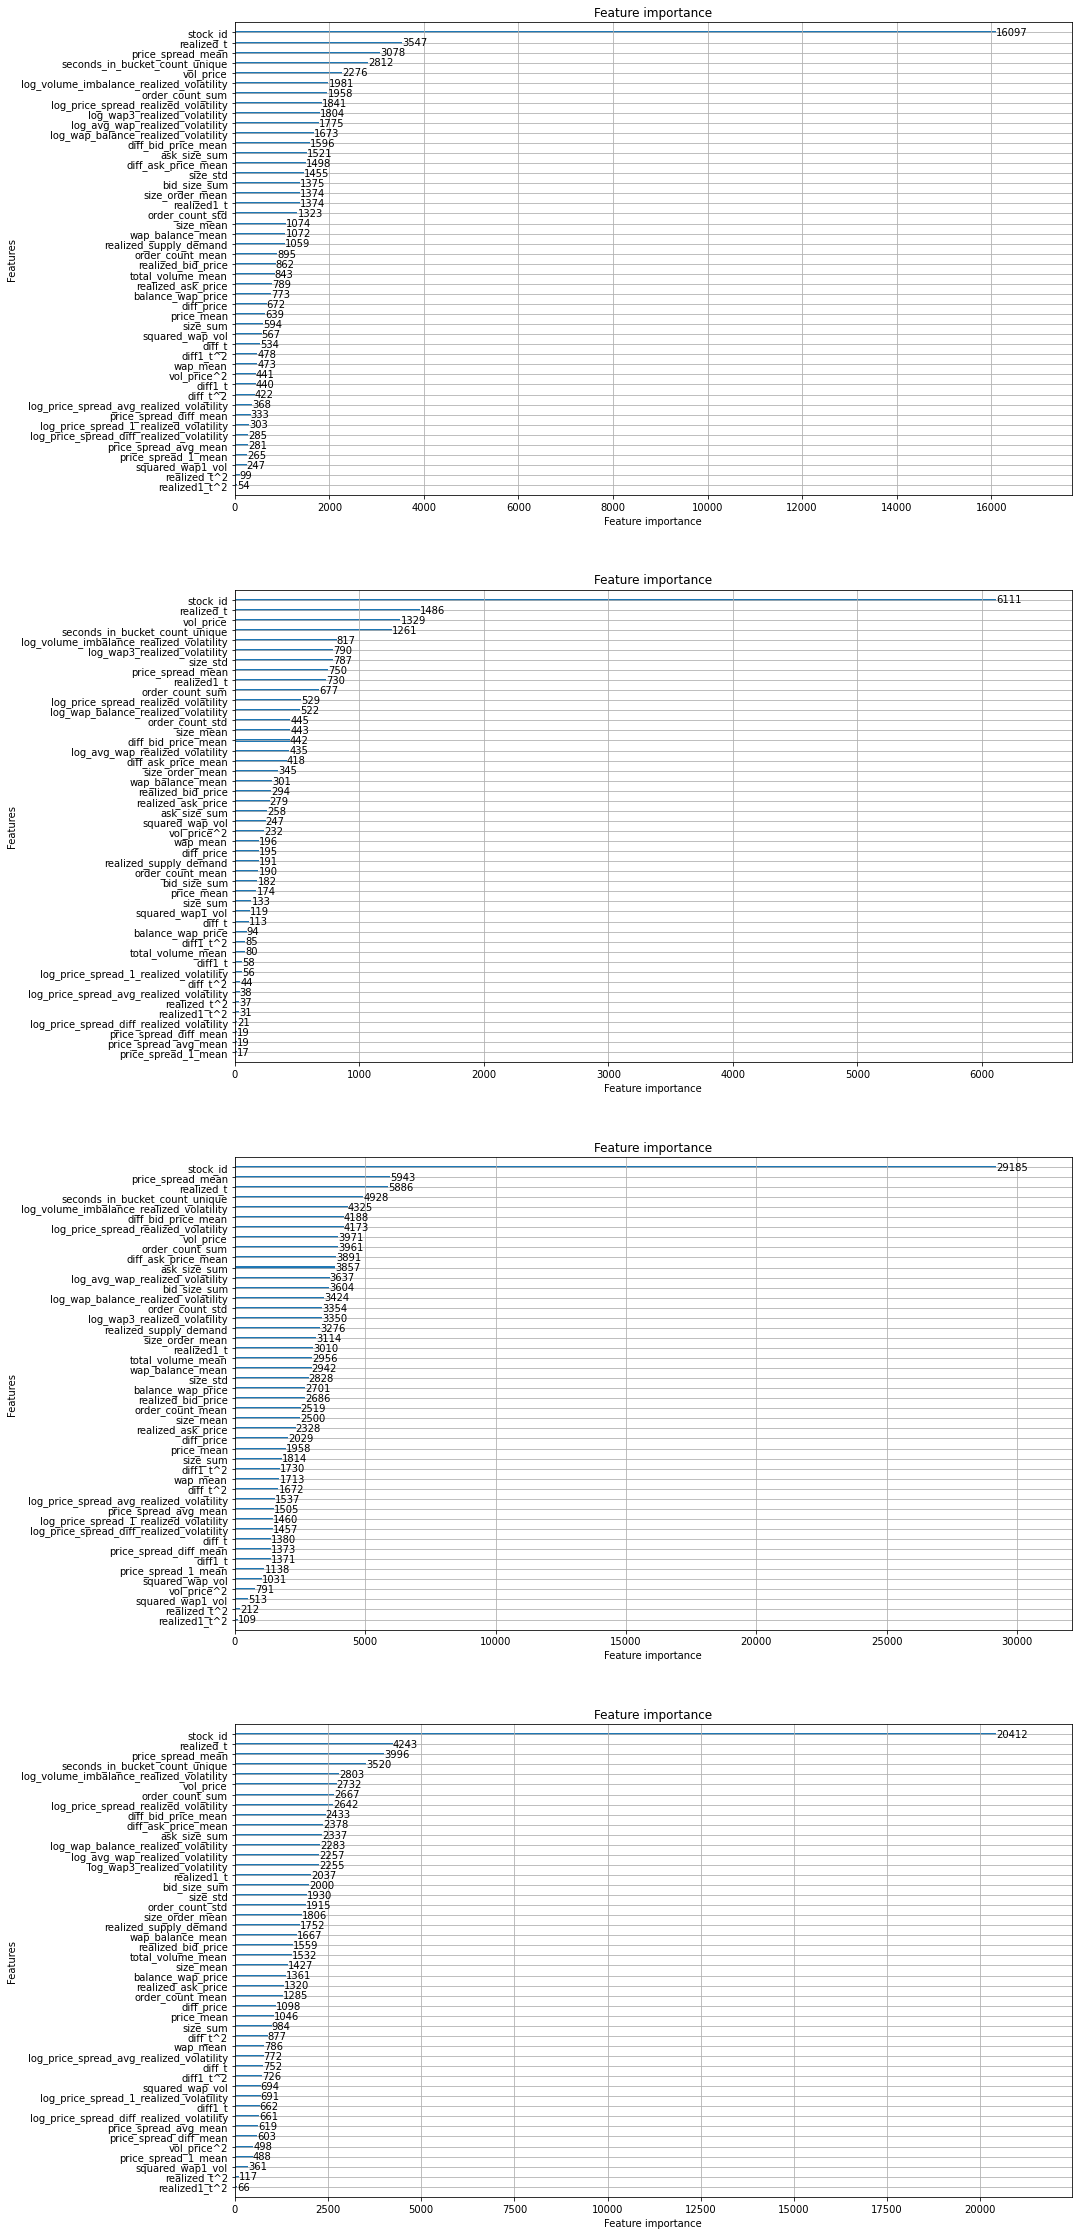

In [160]:
fig ,ax  = plt.subplots(4,1,figsize=(15,40))
for i in range(4) :
    lgbm.plot_importance(models[i],ax=ax[i])

In [161]:
train_df["cible"] = np.mean(np.vstack([model.predict(train_df[retained_features]) for model in models]),axis=0)

In [162]:
RMSPE = round(rmspe(y_true = train_df['target'], y_pred = train_df['cible']),3)
print(f'Performance of LGBM model  RMSPE: {RMSPE}')

Performance of LGBM model  RMSPE: 0.22


# 5.Submission :

In [163]:
test_all_files = glob.glob("../input/optiver-realized-volatility-prediction/book_test.parquet/*")

In [164]:
data_test_all_files = preprocessing_all_files(test_all_files)

In [165]:
test_df = merge_and_create_feature_engineering(test,data_test_all_files)

In [166]:
test_df = merge_and_create_feature_engineering_for_second_level(test_df)

In [167]:
files_test = glob.glob("../input/optiver-realized-volatility-prediction/trade_test.parquet/*")
trade_stock = preprocessing_trade_all_file(files_test)

In [168]:
test_df = test_df.merge(trade_stock,how="left",on="row_id")

In [169]:
test_df["vol_price^2"] = test_df["vol_price"] ** 2

In [170]:
del(test_df["stock_id_y"])
del(test_df["time_id_y"])

In [171]:
test_df.rename(columns={"time_id_x":"time_id"},inplace=True)
test_df.rename(columns={"stock_id_x":"stock_id"},inplace=True)


In [172]:
test_df["vol_price_1"] = test_df.groupby("stock_id")["vol_price"].shift(1)
ind = np.where(test_df["vol_price_1"].isna())[0]
for i in ind :
    test_df.loc[i,"vol_price_1"] = test_df.loc[i,"vol_price"]

In [173]:
test_df["diff_price"] = test_df["vol_price"] - test_df["vol_price_1"]
del(test_df["vol_price_1"])

In [174]:
test_df["balance_wap_price"] = abs(test_df["price_mean"]- \
                                           test_df["wap_mean"])

In [175]:
test_df["prediction"] = np.mean(np.vstack([model.predict(test_df[retained_features]) for model in models]),axis=0)

In [176]:
test_df.rename(columns={"prediction":"target"},inplace=True)

In [177]:
test_df[["row_id","target"]].to_csv("submission.csv",index=False)

In [178]:
train_df.to_csv("train_df",index=False)